In [17]:
!pip install ultralytics

In [42]:
from ultralytics import YOLO
yolo_model = YOLO('yolov8s.pt')

#model = YOLO('yolov8s.pt')  # Works better with the Ultralytics package


#Prtrained model used for indian traffic

In [43]:

#yolo_model = YOLO('yolo_indian_traffic.pt')

In [44]:
from google.colab.patches import cv2_imshow

In [45]:
import cv2
import torch
import numpy as np
import pandas as pd
import random
from collections import deque
import gym
#from ultralytics import YOLO
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [46]:
def count_vehicles_from_frame(frame, model):
    results = model.predict(source=frame, verbose=False)
    count = 0
    for r in results:
        boxes = r.boxes
        if boxes is not None:
            for box in boxes:
                cls = int(box.cls[0].item())  # class ID
                if cls in [2, 3, 5, 7]:  # car, motorcycle, bus, truck
                    count += 1
    return count


In [47]:
'''def extract_vehicle_counts(video_path, model, max_frames=200):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    vehicle_counts = []

    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        count = count_vehicles_from_frame(frame, model)
        vehicle_counts.append(count)

        frame_count += 1
        cv2.putText(frame, f"Count: {count}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2_imshow(frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    return vehicle_counts
'''



def extract_vehicle_counts(video_path, yolo_model, max_frames=1000):
    cap = cv2.VideoCapture(video_path)
    counts = []
    frame_count = 0

    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        results = yolo_model(frame)  # Predict vehicles
        detections = results[0].boxes.cls.cpu().numpy()  # Detected class IDs

        # If needed, filter specific classes (assuming your custom model uses these labels)
        vehicle_classes = [0, 1, 2, 3]  # 0: car, 1: bike, 2: truck, 3: bus
        vehicle_count = sum([1 for cls in detections if cls in vehicle_classes])

        counts.append(vehicle_count)
        frame_count += 1

    cap.release()
    return counts


In [48]:
# ===============================
# Part 2: Traffic Flow Prediction
# ===============================

def create_lstm_model(seq_length):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def prepare_lstm_data(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

In [49]:
# =====================================
# Part 3: Traffic Signal Control (DQN)
# =====================================

def build_dqn_model(state_size, action_size):
    model = Sequential([
        Dense(24, input_dim=state_size, activation='relu'),
        Dense(24, activation='relu'),
        Dense(action_size, activation='linear')
    ])
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

[INFO] Loading YOLO model...
[INFO] Extracting vehicle counts from video...

0: 384x640 4 persons, 13 cars, 6 motorcycles, 2 buss, 10 trucks, 6 potted plants, 401.2ms
Speed: 3.4ms preprocess, 401.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 16 cars, 6 motorcycles, 2 buss, 9 trucks, 5 potted plants, 340.3ms
Speed: 4.1ms preprocess, 340.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 16 cars, 7 motorcycles, 2 buss, 8 trucks, 4 potted plants, 352.1ms
Speed: 4.3ms preprocess, 352.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 15 cars, 6 motorcycles, 1 bus, 6 trucks, 5 potted plants, 336.3ms
Speed: 4.0ms preprocess, 336.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 14 cars, 5 motorcycles, 1 bus, 8 trucks, 5 potted plants, 345.1ms
Speed: 4.2ms preprocess, 345.1ms inference, 1.4ms postprocess per image at shape (1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1812
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0266
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0199
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0209
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0216
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0221
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0210
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0225
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0174
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0209
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0161
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0245
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0198
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0215
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0186
Epoch 16/50
19/19 ━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self._numpy())
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense

[PREDICTION] Predicted Traffic Flow: 21.16 vehicles
[CONTROL] DQN chose action: 1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 


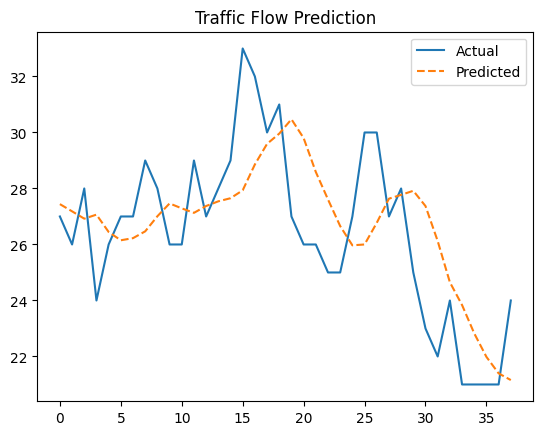

In [50]:
# ===============================
# Main Integration
# ===============================

def main():
    # Load YOLO model
    print("[INFO] Loading YOLO model...")
    yolo_model = YOLO('yolov8s.pt')

    # Extract vehicle counts from video
    print("[INFO] Extracting vehicle counts from video...")
    video_path = 'TrafficSmart.mp4'
    vehicle_counts = extract_vehicle_counts(video_path, yolo_model, max_frames=200)
    traffic_data = np.array(vehicle_counts).reshape(-1, 1)

    # Normalize data
    scaler = MinMaxScaler()
    traffic_data_scaled = scaler.fit_transform(traffic_data)

    # Prepare LSTM input
    seq_length = 10
    X, y = prepare_lstm_data(traffic_data_scaled, seq_length)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Train LSTM model
    print("[INFO] Training LSTM model...")
    lstm_model = create_lstm_model(seq_length)
    lstm_model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1)

    # Predict next traffic flow
    last_seq = X_test[-1].reshape(1, seq_length, 1)
    predicted_flow = lstm_model.predict(last_seq)
    predicted_flow_val = scaler.inverse_transform(predicted_flow)[0][0]
    print(f"[PREDICTION] Predicted Traffic Flow: {predicted_flow_val:.2f} vehicles")

    # Simulated Control: DQN chooses action based on predicted flow
    env = gym.make('CartPole-v1')  # Replace with real traffic env if available
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    dqn_model = build_dqn_model(state_size, action_size)


    # Just simulate one step for demo
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    q_values = dqn_model.predict(state, verbose=0)
    action = np.argmax(q_values[0])
    print(f"[CONTROL] DQN chose action: {action}")



    # Visual summary
    plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1))[:100], label="Actual")
    plt.plot(scaler.inverse_transform(lstm_model.predict(X_test[:100])), label="Predicted", linestyle="--")
    plt.title("Traffic Flow Prediction")
    plt.legend()
    plt.show()

if __name__ == '__main__':
    main()
